# Project Description:

This project uses a LSTM model to predict the Closing Price of Selected Stock by taking the Opening Price, High and Economic Sentiment as inputs.

### 1. Importing libraries / Defining methods and constants

In [138]:
# Import Sequences

# datetime is used to format dates in both .csv files
from datetime import datetime

# Numpy is used for working with output array etc
import numpy as np

# Pandas is used to work with CSV data
import pandas as pd

# Plotting the training loss, model performance
import matplotlib.pyplot as plt

# Import the Standard Scaler, used for scaling the input data to avoid bias
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used to compute model performance
from sklearn.metrics import mean_squared_error

# Used to split the data into training and testing datasets
from sklearn.model_selection import train_test_split #, TimeSeriesSplit

# Used to define the layers which are used in the model
from keras.layers import Dense, LSTM

# Defining the type of model
from keras.models import Sequential

# Additional import, can be used to stop training early
from keras.callbacks import EarlyStopping


# Defining the Variables, Constants, and Dataset

# Stock Data
stock_CSV = "/content/netflix.csv"

# Sentiment Data
sentiment_CSV = "/content/news_sentiment_data.csv"

# Defining the figure size for all the plots
FIG_SIZE = (14,6)



In [139]:
'''
NOTE: The following functions were generated using GPT 3.5 and modified as needed.
'''

#
def date_format(date_column):
    """
    Reformat the dates of given DataFrame column.

    Parameters:
    date_column:  The column containing the dates to be reformatted.

    Returns:
    formatted_dates:  The list of reformatted dates.
    """
    formats_to_try = ['%m/%d/%Y', '%d-%m-%Y']
    formatted_dates = []

    for date_str in date_column:
        formatted_date = None
        for fmt in formats_to_try:
            try:
                date_obj = datetime.strptime(date_str, fmt)
                formatted_date = date_obj.strftime('%d/%m/%Y')
                break
            except ValueError:
                pass
        formatted_dates.append(formatted_date)

    return formatted_dates
#


#
def lstm_split(data , n_steps):
    """
    Split the dataset into X , y and output both subsets.

    Parameters:
    data:     The data to be split.
    n_steps:  N steps of the timeseries

    Returns:
    X , y :   Numpy arrays which are subsets of data.
    """

    X , y = [] , []
    for i in range(len(data) - n_steps+1):
      X.append(data[i:i + n_steps, :-1])
      y.append(data[i + n_steps-1, -1])

    return np.array(X) , np.array(y)
#


#
def get_prediction(model , input):
    """
    Get the model predictions for given scaled data

    Parameters:
    model:  The model from which predictions are obtained
    input:  The input data to be fed to model.

    Returns:
    prediction: 1D array containing the predictions
    """

    prediction = model.predict(input)

    prediction = prediction.squeeze()
    prediction = np.mean(prediction , axis = 1)

    return prediction
#


#
def calculate_percent_difference(array1, array2):
    """
    Calculate the percentage difference between array1 and array2.

    Parameters:
    array1 (numpy.ndarray): The first array of values.
    array2 (numpy.ndarray): The second array of values.

    Returns:
    numpy.ndarray: An array containing the percentage difference between corresponding elements.
    """
    if array1.shape != array2.shape:
        raise ValueError("Input arrays must have the same shape.")

    percent_difference = ((array2 - array1) / array1) * 100.0

    return percent_difference
#

### 2. Creating the Data Set

In [140]:
# Create DataFrames for stock and sentiment data
sentiment_data = pd.read_csv(sentiment_CSV)
stock_data = pd.read_csv(stock_CSV)

In [141]:
# Cleaning sentiment_data changing datatypes to float.
sentiment_data['date'] = date_format(sentiment_data['date'])
sentiment_data.rename(columns={'date':'Date'}, inplace=True)
sentiment_data.rename(columns={'News Sentiment':'Sentiment'}, inplace=True)
sentiment_data['Sentiment'] = sentiment_data['Sentiment'].astype(float)

# Cleaning stock_data, removing the $ symbol from data and changing datatypes to float.
stock_data['Date'] = date_format(stock_data['Date'])
stock_data['Open'] = stock_data['Open'].str.replace('$', '').astype(float)
stock_data['Close/Last'] = stock_data['Close/Last'].str.replace('$', '').astype(float)
stock_data['High'] = stock_data['High'].str.replace('$', '').astype(float)
stock_data['Low'] = stock_data['Low'].str.replace('$', '').astype(float)


<ipython-input-141-1ef9bf4be036>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data['Open'] = stock_data['Open'].str.replace('$', '').astype(float)
<ipython-input-141-1ef9bf4be036>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data['Close/Last'] = stock_data['Close/Last'].str.replace('$', '').astype(float)
<ipython-input-141-1ef9bf4be036>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data['High'] = stock_data['High'].str.replace('$', '').astype(float)
<ipython-input-141-1ef9bf4be036>:12: Futu

In [142]:
# Merging both the sentiment_data and stock_data to create singular dataset
dataset = sentiment_data.merge(stock_data, left_on='Date', right_on='Date')

In [143]:
# Viewing the merged dataset
dataset

,Date,Sentiment,Close/Last,Volume,Open,High,Low
0,21/08/2013,0.05,38.6243,21240197,38.9843,39.2357,38.2143
1,22/08/2013,0.04,38.5357,9961507,38.9314,39.0657,38.3186
2,23/08/2013,0.06,39.7657,22322384,38.5786,39.7700,38.4314
3,26/08/2013,0.05,40.3886,30688779,39.4443,41.4206,39.1486
4,27/08/2013,0.05,39.4343,23054850,39.8786,40.8400,39.2143
...,...,...,...,...,...,...,...
2506,07/08/2023,-0.05,440.7600,4781303,436.4550,441.1100,428.9057
2507,08/08/2023,-0.06,438.3000,3767195,440.3600,443.5700,435.1000
2508,09/08/2023,-0.07,428.9000,3846639,439.7400,440.6200,427.5900
2509,10/08/2023,-0.06,429.9800,5467607,431.1200,438.1200,428.6900


In [144]:
# Take target as Closing price, features are Open, High and Sentiment
target = dataset['Close/Last']
features = dataset[['Open' , 'High', 'Low' , 'Sentiment']]

In [145]:
# Feature Scaling

# Defining the scaler as sc
sc = StandardScaler()

# Transform the features using the scaler, create a new dataframe X_ft
X_ft = sc.fit_transform(features.values)
X_ft = pd.DataFrame(columns = features.columns , data = X_ft , index = features.index )

In [146]:
# Merge features and target into Scaled Dataset
scaled_dataset = X_ft.assign(Close = target)

# View the scaled dataset
scaled_dataset

,Open,High,Low,Sentiment,Close
0,-1.314361,-1.318735,-1.313716,0.330548,38.6243
1,-1.314675,-1.319732,-1.313087,0.275555,38.5357
2,-1.316771,-1.315603,-1.312406,0.385541,39.7657
3,-1.311627,-1.305928,-1.308080,0.330548,40.3886
4,-1.309047,-1.309331,-1.307684,0.330548,39.4343
...,...,...,...,...,...
2506,1.047409,1.036982,1.042926,-0.219380,440.7600
2507,1.070612,1.051402,1.080290,-0.274373,438.3000
2508,1.066928,1.034110,1.034990,-0.329365,428.9000
2509,1.015708,1.019455,1.041625,-0.274373,429.9800


In [147]:
# Splitting data into train and test sets

# Defining the amount of inputs to be considered
N_STEPS = 2

# Splitting the scaled dataset into X and y via lstm_split()
X , y = lstm_split(scaled_dataset.values, n_steps = N_STEPS)


In [148]:
# Defining quantity of data to be used for training (80% = 0.8)
train_split = 0.8

# Defining the index used to split X , y into x_train, x_test, y_train and y_test.
split_index = int(np.ceil(len(X)*train_split))


In [149]:
# Splitting X, y
x_train , x_test = X[:split_index] , X[split_index:]
y_train , y_test = y[:split_index] , y[split_index:]

# Print the shapes
print(X.shape , x_train.shape , x_test.shape , y_test.shape)

(2510, 2, 4) (2008, 2, 4) (502, 2, 4) (502,)


### 3. Compiling and Training the Model

In [150]:
# Building the model
EPOCHS = 100
BATCH_SIZE = 2
LOSS = 'mean_squared_error'
OPTIMIZER = 'adam'
ACTIVATION = 'relu'
input_units = 32
output_units = 1

model = Sequential()
model.add( LSTM(input_units , input_shape=(x_train.shape[1],x_train.shape[2] ), activation=ACTIVATION , return_sequences=True))
model.add( LSTM((input_units//2) ,activation=ACTIVATION, return_sequences = True))
model.add(Dense(output_units))
model.compile( loss = LOSS, optimizer = OPTIMIZER)

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 2, 32)             4736      
                                                                 
 lstm_26 (LSTM)              (None, 2, 16)             3136      
                                                                 
 dense_13 (Dense)            (None, 2, 1)              17        
                                                                 
Total params: 7,889
Trainable params: 7,889
Non-trainable params: 0
_________________________________________________________________


In [151]:
# Train the model and store training history
history = model.fit(x_train , y_train, epochs=EPOCHS , batch_size=BATCH_SIZE, shuffle=False)

Epoch 1/100
1004/1004 [==============================] - 6s 4ms/step - loss: 37282.2383
Epoch 2/100
1004/1004 [==============================] - 5s 5ms/step - loss: 10543.2090
Epoch 3/100
1004/1004 [==============================] - 4s 4ms/step - loss: 1349.5619
Epoch 4/100
1004/1004 [==============================] - 4s 4ms/step - loss: 899.0159
Epoch 5/100
1004/1004 [==============================] - 4s 4ms/step - loss: 595.9081
Epoch 6/100
1004/1004 [==============================] - 4s 4ms/step - loss: 343.4102
Epoch 7/100
1004/1004 [==============================] - 4s 4ms/step - loss: 206.4526
Epoch 8/100
1004/1004 [==============================] - 4s 4ms/step - loss: 136.3773
Epoch 9/100
1004/1004 [==============================] - 5s 4ms/step - loss: 102.1632
Epoch 10/100
1004/1004 [==============================] - 3s 3ms/step - loss: 86.3621
Epoch 11/100
1004/1004 [==============================] - 4s 4ms/step - loss: 79.5811
Epoch 12/100
1004/1004 [=========================

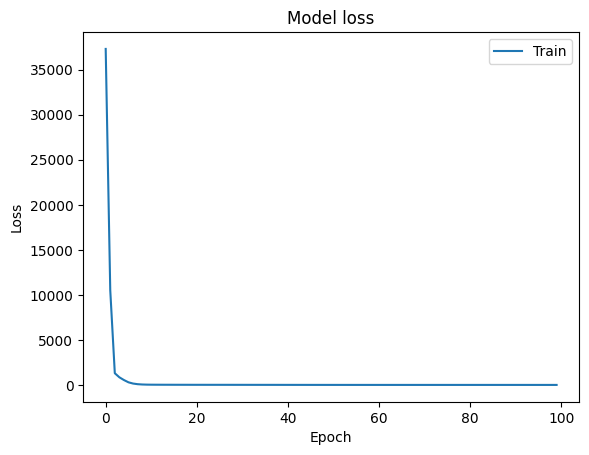

In [158]:
# Plot the training losses of model
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### 4. Testing the Model and Plotting Results

In [159]:
# Test the model using predict()
y_pred = get_prediction(model , x_test)


16/16 [==============================] - 0s 2ms/step


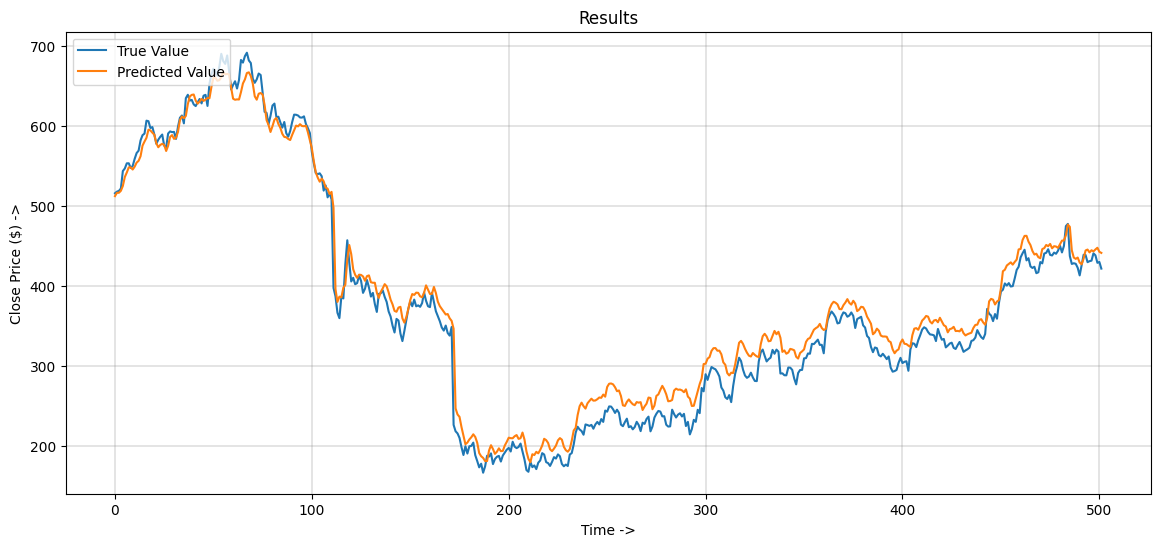

In [160]:
#Plot the True Values V/S Predicted Values
plt.figure(figsize=FIG_SIZE)
plt.grid(True, color = 'grey', linewidth = '0.3')

plt.plot(y_test , label='True Value')
plt.plot(y_pred, label='Predicted Value')

plt.legend(loc='upper left')
plt.xlabel("Time ->")
plt.ylabel("Close Price ($) ->")
plt.title("Results")
plt.show()

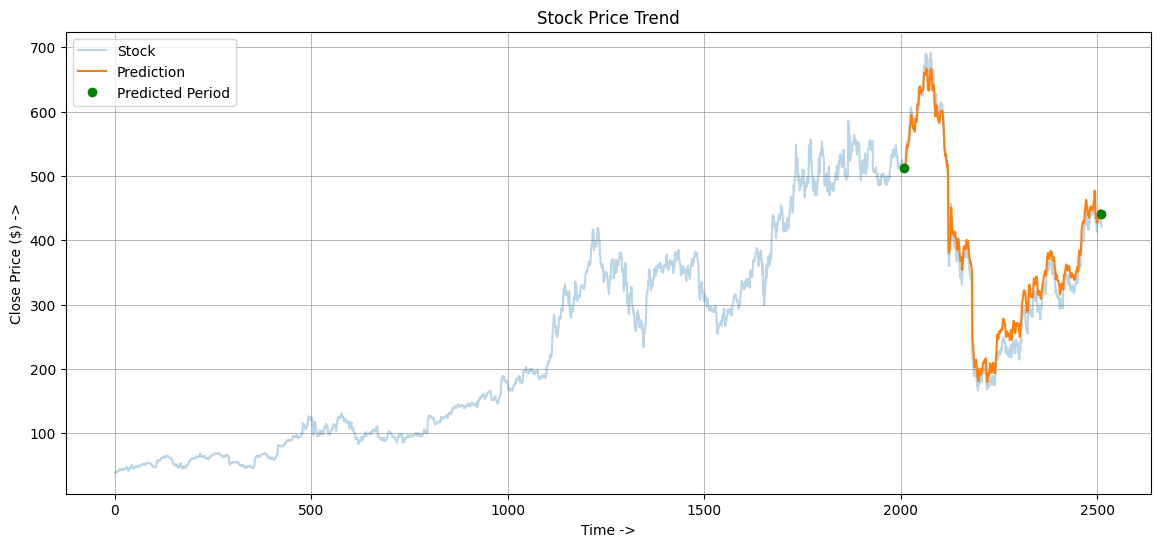

In [161]:
#This plot shows the entire stock data along with the output predictions

# Set the point on the X-axis where array should start
start_point = len(dataset['Close/Last'].values) - len(y_pred)

# Generate X-values for array that start from the set point
x_values_A2 = np.arange(start_point, start_point + len(y_pred.reshape(-1)))

# Create the plot
plt.figure(figsize=FIG_SIZE)
plt.grid(True, color = 'grey', linewidth = '0.4')
plt.plot(dataset['Close/Last'].values,label="Stock", alpha=0.3)

plt.plot(x_values_A2,y_pred.reshape(-1),  label="Prediction")
plt.plot(x_values_A2[0], y_pred[0],'o', color='green' , label="Predicted Period")
plt.plot(x_values_A2[-1], y_pred[-1],'o' , color='green')


plt.legend(loc='upper left')
plt.xlabel("Time ->")
plt.ylabel("Close Price ($) ->")
plt.title("Stock Price Trend")

plt.show()

Accuracy is: 94.81621502313794


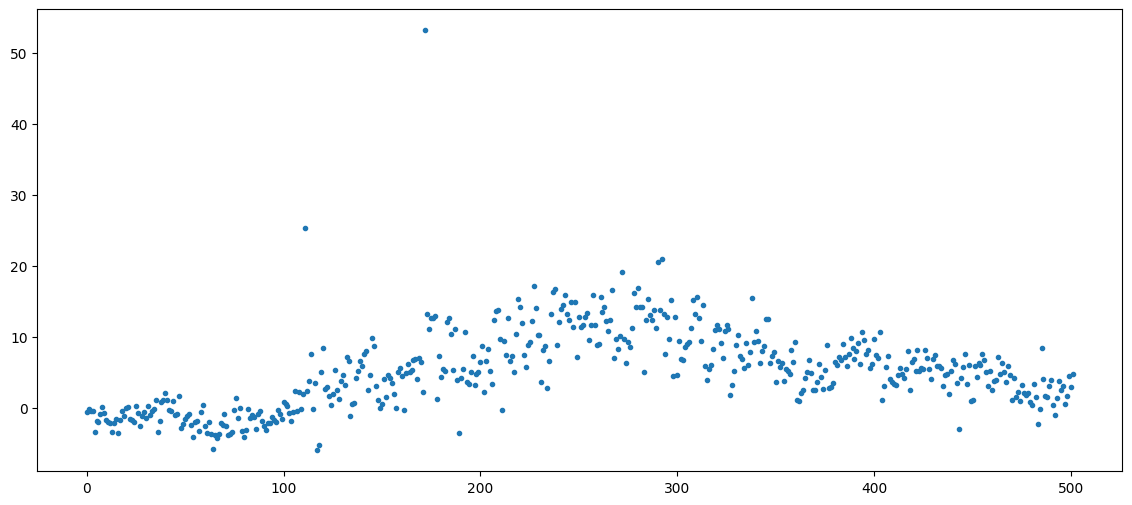

In [162]:
percent_diff = calculate_percent_difference(y_test, y_pred.reshape(-1))

average_percent_diff = np.mean(percent_diff)

plt.figure(figsize=FIG_SIZE)
plt.plot((percent_diff), '.')

print('Accuracy is:',100 - np.abs(average_percent_diff))

#### Optional: Export Model for later use.

In [157]:
# Change this according to the data
model.save('stock_model_LSTM.h5')